In [1]:
import os
import pandas as pd
import numpy as np
from nilearn import image, input_data
from statsmodels.tsa.stattools import grangercausalitytests
import sys
import nibabel as nib

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = params.raw_dir
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = ['sub-025']  # Update this list as needed
rois = ['pIPS', 'LO']  # We'll analyze the relationship between these two ROIs
hemispheres = ['left', 'right']
run_num = 3
runs = list(range(1, run_num + 1))
run_combos = [[rn1, rn2] for rn1 in range(1, run_num + 1) for rn2 in range(rn1 + 1, run_num + 1)]

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
import pandas as pd
ss = 'sub-025'  

# Replace with your actual file path
results_file = f'{study_dir}/{ss}/ses-01/derivatives/gca/{ss}_gca_results.csv'

# Read the CSV file
results = pd.read_csv(results_file)

# Display the first few rows
print(results.head())

# Get some basic statistics
print(results.describe())

# results for a specific condition or hemisphere
print(results[results['condition'] == 'Object'])
print(results[results['hemisphere'] == 'left'])

   run_combo hemisphere condition    f_diff
0          0       left    Object  3.119555
1          1       left    Object  1.390529
2          2       left    Object -0.377385
3          0      right    Object  7.910501
4          1      right    Object  0.014064
       run_combo    f_diff
count   6.000000  6.000000
mean    1.000000  2.231307
std     0.894427  3.042430
min     0.000000 -0.377385
25%     0.250000  0.343192
50%     1.000000  1.360553
75%     1.750000  2.687299
max     2.000000  7.910501
   run_combo hemisphere condition    f_diff
0          0       left    Object  3.119555
1          1       left    Object  1.390529
2          2       left    Object -0.377385
3          0      right    Object  7.910501
4          1      right    Object  0.014064
5          2      right    Object  1.330576
   run_combo hemisphere condition    f_diff
0          0       left    Object  3.119555
1          1       left    Object  1.390529
2          2       left    Object -0.377385


Summary of f_diff values by subject and hemisphere:
                        mean       std       min        max
subject hemisphere                                         
sub-025 left        1.377566  1.748506 -0.377385   3.119555
        right       3.085047  4.230491  0.014064   7.910501
sub-038 left       -1.145075  3.931375 -5.564603   1.962763
        right       3.231165  7.827981 -2.279191  12.191524
sub-057 left        2.521708  2.757221  0.838965   5.703710
        right       0.352421  2.669557 -2.727968   1.992292
sub-059 left        0.785552  1.358420 -0.178014   2.339232
        right      -1.549530  0.049309 -1.592573  -1.495732

    run_combo hemisphere condition     f_diff  subject
11          2      right    Object  12.191524  sub-038

Overall statistics:
count    24.000000
mean      1.082357
std       3.602031
min      -5.564603
25%      -0.656972
50%       0.517202
75%       1.970145
max      12.191524
Name: f_diff, dtype: float64


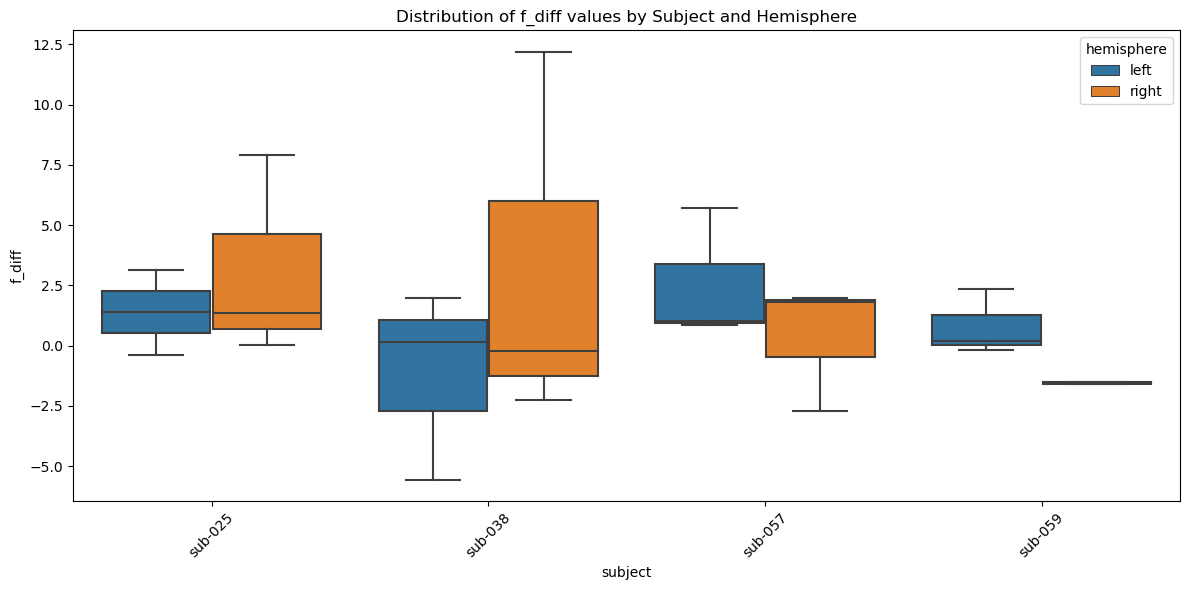

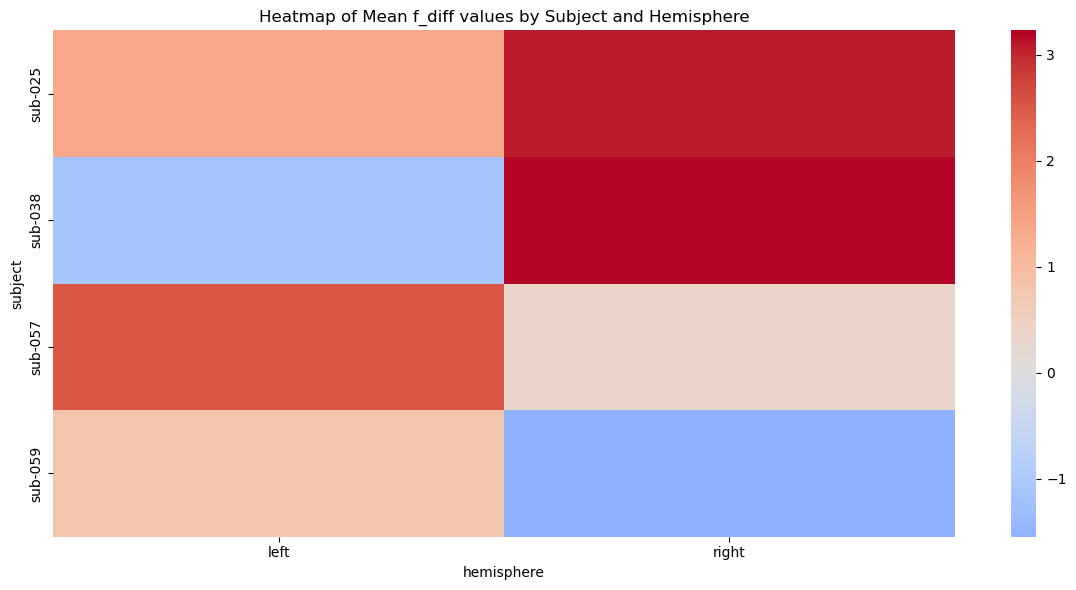

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
subs = ['sub-025', 'sub-038', 'sub-057', 'sub-059']  # Add all your subjects here

def review_native_space_gca(study_dir, subs):
    all_results = []

    for ss in subs:
        gca_results_path = f'{study_dir}/{ss}/ses-01/derivatives/gca/{ss}_gca_results.csv'
        if not os.path.exists(gca_results_path):
            print(f"Results not found for subject {ss}")
            continue

        gca_df = pd.read_csv(gca_results_path)
        gca_df['subject'] = ss
        all_results.append(gca_df)

    # Combine all results
    all_results_df = pd.concat(all_results, ignore_index=True)

    # Summary statistics
    summary = all_results_df.groupby(['subject', 'hemisphere'])['f_diff'].agg(['mean', 'std', 'min', 'max'])
    print("Summary of f_diff values by subject and hemisphere:")
    print(summary)

    # Visualizations
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='subject', y='f_diff', hue='hemisphere', data=all_results_df)
    plt.title('Distribution of f_diff values by Subject and Hemisphere')
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.savefig(f'{study_dir}/native_space_gca_boxplot.png')
    #plt.close()

    plt.figure(figsize=(12, 6))
    sns.heatmap(all_results_df.groupby(['subject', 'hemisphere'])['f_diff'].mean().unstack(), 
                cmap='coolwarm', center=0)
    plt.title('Heatmap of Mean f_diff values by Subject and Hemisphere')
    plt.tight_layout()
    #plt.savefig(f'{study_dir}/native_space_gca_heatmap.png')
    #plt.close()

    # Basic quality checks
    extreme_values = all_results_df[np.abs(all_results_df['f_diff']) > 3 * all_results_df['f_diff'].std()]
    if not extreme_values.empty:
        print("\nWarning: Extreme f_diff values detected:")
        print(extreme_values)

    zero_diff = all_results_df[all_results_df['f_diff'] == 0]
    if not zero_diff.empty:
        print("\nWarning: Zero f_diff values detected:")
        print(zero_diff)

    return all_results_df, summary

# Main execution
if __name__ == "__main__":
    # Define your study directory and subject list
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    subs = ['sub-025', 'sub-038', 'sub-057', 'sub-059']  # Add all your subjects here

    all_results_df, summary = review_native_space_gca(study_dir, subs)

    # Additional analysis or printing can be done here
    print("\nOverall statistics:")
    print(all_results_df['f_diff'].describe())

    # You might want to save the combined results
    all_results_df.to_csv(f'{study_dir}/all_native_space_gca_results.csv', index=False)

In [6]:
import os
import pandas as pd
import numpy as np

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# List of subjects
subs = ['sub-025','sub-038','sub-057','sub-059','sub-064','sub-067','sub-068','sub-071',
        'sub-083', 'sub-084', 'sub-085', 'sub-087', 'sub-088', 'sub-093', 'sub-094', 'sub-095',
        'sub-096', 'sub-097', 'sub-107']

# List of ROI pairs
roi_pairs = ['lpIPS-lLO', 'lpIPS-rLO', 'rpIPS-lLO', 'rpIPS-rLO']

# Initialize the results dataframe
results_df = pd.DataFrame(columns=['sub'] + roi_pairs)

for sub in subs:
    sub_dir = f'{study_dir}/{sub}/ses-01/'
    gca_file = f'{sub_dir}/derivatives/results/gca/gca_summary.csv'
    
    if not os.path.exists(gca_file):
        print(f"GCA summary file not found for subject {sub}")
        continue
    
    sub_data = pd.read_csv(gca_file)
    
    # Initialize a dictionary to store the results for this subject
    sub_results = {'sub': sub}
    
    for pair in roi_pairs:
        origin, target = pair.split('-')
        
        # Filter the data for this ROI pair
        pair_data = sub_data[(sub_data['origin'] == origin) & (sub_data['target'] == target)]
        
        if pair_data.empty:
            print(f"No data found for ROI pair {pair} in subject {sub}")
            sub_results[pair] = np.nan
        else:
            # Calculate the mean f_diff across all folds for this ROI pair
            mean_f_diff = pair_data['f_diff'].mean()
            sub_results[pair] = mean_f_diff
    
    # Append this subject's results to the dataframe
    results_df = results_df.append(sub_results, ignore_index=True)

# Save the results
output_file = f'{results_dir}/gca/subject_roi_pair_summary.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Display the first few rows of the results
print(results_df.head())

Results saved to /user_data/csimmon2/git_repos/ptoc/results/gca/subject_roi_pair_summary.csv
       sub  lpIPS-lLO  lpIPS-rLO  rpIPS-lLO  rpIPS-rLO
0  sub-025  14.692088   4.266910   0.123204  -5.179421
1  sub-038  45.565841   5.500158   6.536933   1.190479
2  sub-057   2.965552  28.993555   3.942061  23.668158
3  sub-059   7.516410   3.647638   3.538479 -15.302817
4  sub-064   0.584504   2.724170   1.388857   3.334944


/tmp/ipykernel_11375/2119858401.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(sub_results, ignore_index=True)
/tmp/ipykernel_11375/2119858401.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(sub_results, ignore_index=True)
/tmp/ipykernel_11375/2119858401.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(sub_results, ignore_index=True)
/tmp/ipykernel_11375/2119858401.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(sub_results, ignore_index=True)
/tmp/ipykernel_11375/2119858401.py:49: FutureWarning

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import os

def analyze_gca_results(input_file, output_file, p_threshold=0.05):
    # Read the CSV file
    df = pd.read_csv(input_file)

    # Define the ROI pairs we're interested in
    roi_pairs = ['lpIPS-lLO', 'lpIPS-rLO', 'rpIPS-lLO', 'rpIPS-rLO']

    results = []

    for pair in roi_pairs:
        # Perform Wilcoxon signed-rank test comparing to 0
        statistic, p_value = stats.wilcoxon(df[pair], zero_method="wilcox")
        
        # Calculate effect size (r = Z / sqrt(N))
        effect_size = statistic / np.sqrt(len(df))
        
        # Determine significance
        significant = p_value < p_threshold

        # Split the pair into origin and target
        origin, target = pair.split('-')
        
        results.append({
            'origin': origin,
            'target': target,
            'mean_f_diff': np.mean(df[pair]),
            'std_f_diff': np.std(df[pair], ddof=1),
            'W_statistic': statistic,
            'p_value': p_value,
            'effect_size': effect_size,
            'significant': significant
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Sort results
    results_df = results_df.sort_values(['origin', 'target'])

    # Save results
    results_df.to_csv(output_file, index=False)
    
    return results_df

# Usage
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
input_file = f"{results_dir}/gca/subject_roi_pair_summary.csv"
output_file = f"{results_dir}/gca/gca_results_with_stats.csv"

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

results = analyze_gca_results(input_file, output_file)

# Print results
print(results)

  origin target  mean_f_diff  std_f_diff  W_statistic   p_value  effect_size  \
0  lpIPS    lLO     8.172030   12.627219         18.0  0.000965     4.129483   
1  lpIPS    rLO     6.699216    7.920030         15.0  0.000523     3.441236   
2  rpIPS    lLO     2.084997    7.812375         48.0  0.060207    11.011955   
3  rpIPS    rLO     2.097414    9.038027         65.0  0.241253    14.912023   

   significant  
0         True  
1         True  
2        False  
3        False  


   run_combo hemisphere condition    f_diff
0          0       left    Object  3.119555
1          1       left    Object  1.390529
2          2       left    Object -0.377385
3          0      right    Object  7.910501
4          1      right    Object  0.014064
run_combo       int64
hemisphere     object
condition      object
f_diff        float64
dtype: object


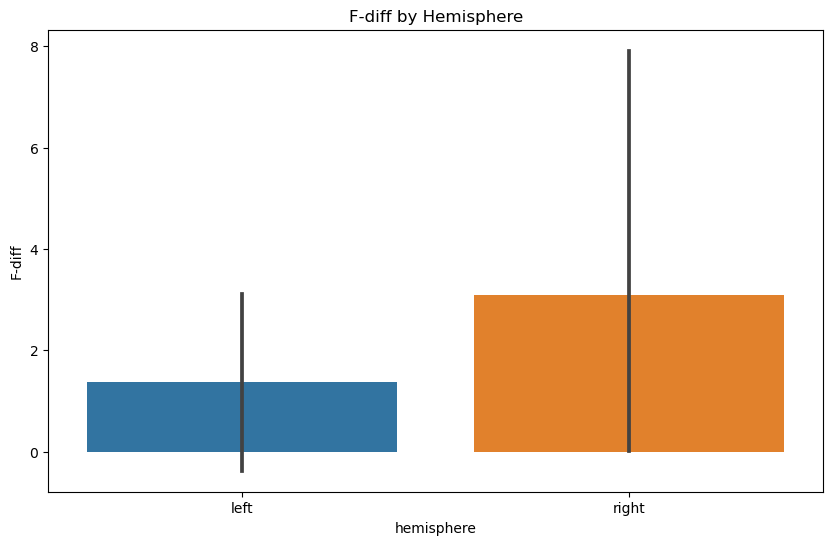

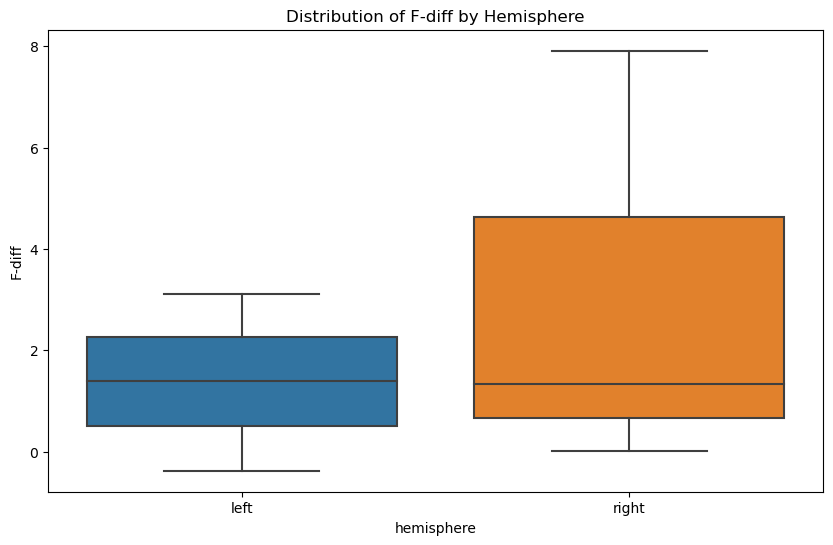


Summary Statistics:
                mean    median       std       min       max
hemisphere                                                  
left        1.377566  1.390529  1.748506 -0.377385  3.119555
right       3.085047  1.330576  4.230491  0.014064  7.910501


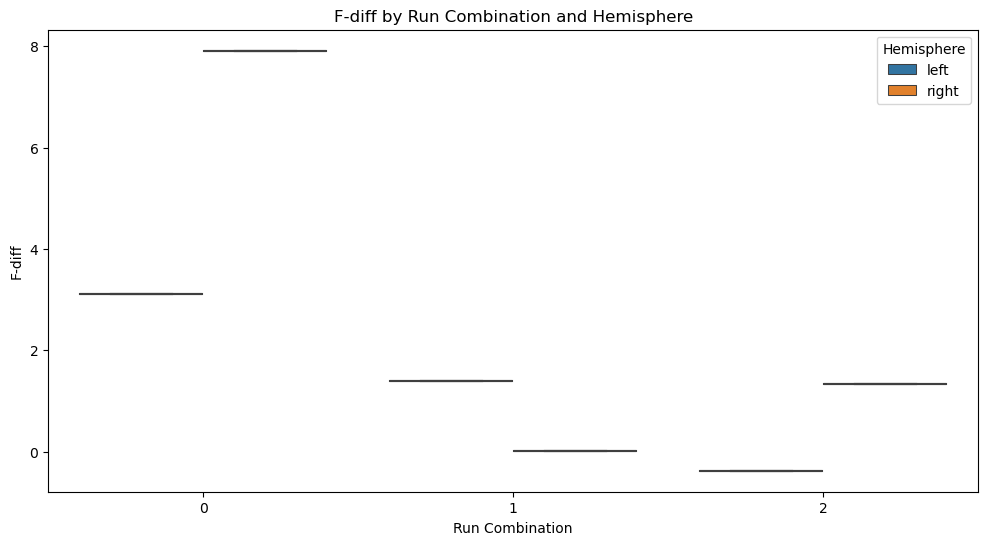

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the path to your CSV file
subject = 'sub-025'  # or whichever subject you're working with
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
gca_results_path = f'{study_dir}/{subject}/ses-01/derivatives/gca/{subject}_gca_results.csv'

# Read the CSV file
results = pd.read_csv(gca_results_path)

# Print the first few rows to verify the data
print(results.head())

# Print column names and data types
print(results.dtypes)

# Create a bar plot of f_diff for each hemisphere
plt.figure(figsize=(10, 6))
sns.barplot(x='hemisphere', y='f_diff', data=results)
plt.title('F-diff by Hemisphere')
plt.ylabel('F-diff')
plt.show()

# Create a box plot of f_diff for each hemisphere
plt.figure(figsize=(10, 6))
sns.boxplot(x='hemisphere', y='f_diff', data=results)
plt.title('Distribution of F-diff by Hemisphere')
plt.ylabel('F-diff')
plt.show()

# Calculate and print summary statistics
summary_stats = results.groupby('hemisphere')['f_diff'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nSummary Statistics:")
print(summary_stats)

# If you have multiple run combinations, you might want to visualize that as well
plt.figure(figsize=(12, 6))
sns.boxplot(x='run_combo', y='f_diff', hue='hemisphere', data=results)
plt.title('F-diff by Run Combination and Hemisphere')
plt.ylabel('F-diff')
plt.xlabel('Run Combination')
plt.legend(title='Hemisphere')
plt.show()

# Save the summary statistics to a CSV file
#summary_stats.to_csv(f'{study_dir}/{subject}/ses-01/derivatives/gca/{subject}_gca_summary_stats.csv')
#print(f"\nSummary statistics saved to: {study_dir}/{subject}/ses-01/derivatives/gca/{subject}_gca_summary_stats.csv")